In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load the provided dataset
file_path = 'Datasets/data_Minimizers.csv'
dataset = pd.read_csv(file_path)

# Display the first few rows and basic information about the dataset
dataset_info = dataset.info()
dataset_head = dataset.head()

dataset_info, dataset_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39470 entries, 0 to 39469
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    39470 non-null  float64
 1   SN      39470 non-null  float64
dtypes: float64(2)
memory usage: 616.8 KB


(None,
           Time         SN
 0  1855.429972  27.906434
 1  1855.432750   9.651062
 2  1855.435528   6.728295
 3  1855.438306   6.997884
 4  1855.441083  21.353002)

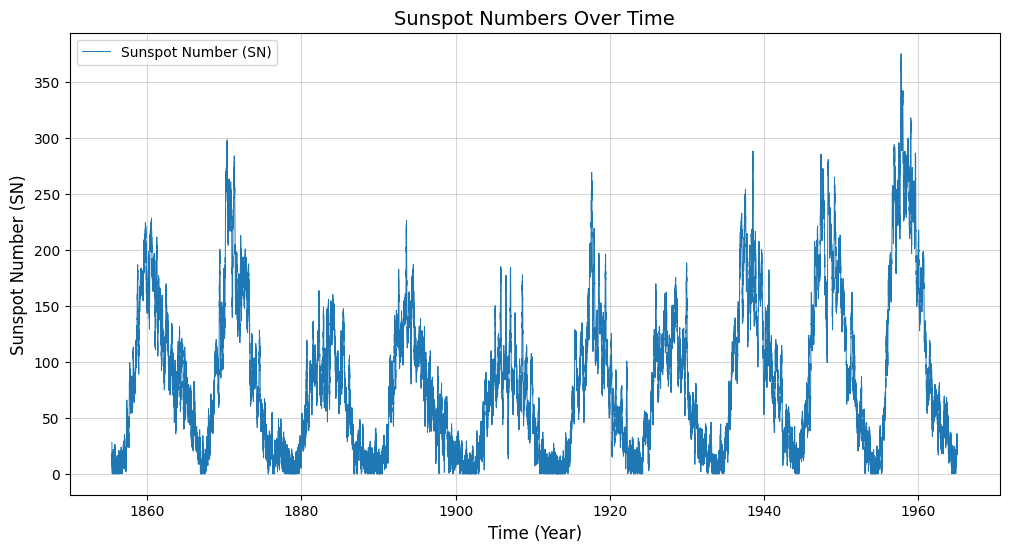

In [39]:


# Plot the Sunspot Number (SN) over Time
plt.figure(figsize=(12, 6))
plt.plot(dataset['Time'], dataset['SN'], label='Sunspot Number (SN)', linewidth=0.7)
plt.title("Sunspot Numbers Over Time", fontsize=14)
plt.xlabel("Time (Year)", fontsize=12)
plt.ylabel("Sunspot Number (SN)", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()


# Simulated Annealing

In [40]:


def simulated_annealing(
    objective_function,
    initial_params,
    param_bounds,
    T0=1.0,
    cooling_rate=0.95,
    max_iterations=1000,
    perturbation_scale=0.1,
    seed=None,
):
    """
    Simulated Annealing (SA) implementation.

    Args:
        objective_function (callable): Function to minimize. Takes parameters as input and returns a scalar value.
        initial_params (np.ndarray): Initial guess for parameters.
        param_bounds (list of tuple): Bounds for each parameter [(min, max), ...].
        T0 (float): Initial temperature.
        cooling_rate (float): Cooling rate for the temperature (0 < cooling_rate < 1).
        max_iterations (int): Number of iterations.
        perturbation_scale (float): Scale of the random parameter perturbations.
        seed (int): Random seed for reproducibility.

    Returns:
        best_params (np.ndarray): Optimized parameters.
        best_objective (float): Objective function value for the best parameters.
    """
    if seed:
        np.random.seed(seed)
    
    # Initialize parameters and temperature
    current_params = np.array(initial_params)
    best_params = current_params.copy()
    current_objective = objective_function(current_params)
    best_objective = current_objective
    T = T0

    for iteration in range(max_iterations):
        # Perturb parameters
        new_params = current_params + np.random.uniform(
            -perturbation_scale, perturbation_scale, size=len(current_params)
        )
        # Enforce parameter bounds
        new_params = np.clip(new_params, [b[0] for b in param_bounds], [b[1] for b in param_bounds])
        
        # Evaluate new solution
        new_objective = objective_function(new_params)

        # Decide whether to accept the new solution
        delta = new_objective - current_objective
        acceptance_probability = np.exp(-delta / T) if delta > 0 else 1.0
        if np.random.rand() < acceptance_probability:
            current_params = new_params
            current_objective = new_objective

        # Update the best solution
        if current_objective < best_objective:
            best_params = current_params.copy()
            best_objective = current_objective

        # Cool down the temperature
        T *= cooling_rate

        # Optional: Print progress (can be commented out for large runs)
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Best Objective = {best_objective:.4f}, T = {T:.4e}")

    return best_params, best_objective




# Function of The Sunspot Number (SN) Over Time and MSE

In [43]:
def solar_cycle_model(params, time_points, num_cycles=10):
    """
    Solar Cycle Model: Computes x(t) based on the provided parameters and time points.

    Args:
        params (np.ndarray): Model parameters (30 in total: T0k, Tsk, Tdk for k=1 to 10).
        time_points (np.ndarray): Array of time points to evaluate the model.
        num_cycles (int): Number of solar cycles (default=10).

    Returns:
        np.ndarray: Model prediction x(t) for the given time points.
    """
    x_t = np.zeros_like(time_points)  # Initialize the model output
    for k in range(num_cycles):
        # Extract parameters for cycle k
        T0k, Tsk, Tdk = params[3 * k : 3 * (k + 1)]
        # Compute x_k(t) for all time points
        x_k = ((time_points - T0k) / Tsk) ** 2 * np.exp(-((time_points - T0k) / Tdk) ** 2)
        x_t += x_k  # Accumulate contributions from each cycle
    return x_t


def objective_function(params, dataset):
    """
    Objective Function: Computes the MSE between the model and observed data.

    Args:
        params (np.ndarray): Model parameters (30 in total: T0k, Tsk, Tdk for k=1 to 10).
        dataset (pd.DataFrame): Dataset containing 'Time' and 'SN' columns.

    Returns:
        float: Mean Squared Error (MSE) between the model and observed data.
    """
    # Predictions from the model
    predictions = solar_cycle_model(params, dataset['Time'].values)
    # Compute MSE
    mse = np.mean((dataset['SN'].values - predictions) ** 2)
    return mse


In [44]:
params = np.random.uniform(0.1, 5, size=30)  # 30 random parameters
predictions = solar_cycle_model(params, dataset['Time'].values)  # Ensure dataset is passed
mse = objective_function(params, dataset)  # Use the corrected function


In [48]:
# Set hyperparameters for SA
T0 = 1.0  # Initial temperature
cooling_rate = 0.95  # Cooling rate
max_iterations = 1000  # Maximum iterations

# Wrap the objective function to include the dataset as a fixed argument
def wrapped_objective_function(params):
    return objective_function(params, dataset)

# Run the Simulated Annealing optimization
optimized_params, optimized_mse = simulated_annealing(
    objective_function=wrapped_objective_function,  # Pass the wrapped function
    initial_params=initial_params,
    param_bounds=param_bounds,
    T0=T0,
    cooling_rate=cooling_rate,
    max_iterations=max_iterations,
    perturbation_scale=0.5,  # Adjusted for parameter range
    seed=42
)

optimized_params, optimized_mse


Iteration 0: Best Objective = 11451.1227, T = 9.5000e-01
Iteration 100: Best Objective = 11451.1227, T = 5.6245e-03
Iteration 200: Best Objective = 11451.1227, T = 3.3300e-05
Iteration 300: Best Objective = 11451.1227, T = 1.9715e-07
Iteration 400: Best Objective = 11451.1227, T = 1.1673e-09
Iteration 500: Best Objective = 11451.1227, T = 6.9108e-12
Iteration 600: Best Objective = 11451.1227, T = 4.0915e-14
Iteration 700: Best Objective = 11451.1227, T = 2.4224e-16
Iteration 800: Best Objective = 11451.1227, T = 1.4342e-18
Iteration 900: Best Objective = 11451.1227, T = 8.4912e-21


(array([1.77122512, 0.65602025, 4.63099873, 4.39896283, 1.36391398,
        3.33392183, 4.10438878, 2.82048398, 2.69528783, 1.28507623,
        0.55620356, 4.49635721, 4.51204848, 3.20219714, 1.76124598,
        1.81112692, 3.65718283, 4.49584027, 4.44672348, 3.92139017,
        3.24595507, 0.51228583, 0.8919807 , 4.50291552, 3.07150239,
        0.14506555, 0.59721056, 3.35115867, 0.12480176, 0.88795945]),
 11451.122675411541)